# Goal

The climate has an enormous effect on the human activity. One of its more apparent factors is temperature. Knowing how the temperature/climate is going to change in the far and near future can help determine if any steps are needed to mitigate the possible effects (i.e. draughts).

The goal of this project is to see if it's possible to predict minimum and maximum temperatures using historical data about monthly temperatures and industrial/economical characteristics from a few countries around the world. This will require developing a supervised regression model using time series data collected from different sources, which will also allow to get a better understanding of what kind of problems might be encountered when working with such data.

# Imports

In [ ]:
from pathlib import Path
import warnings

from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

# Data

The data for this project is going to be downloaded in this notebook from 2 sources: 
- [Climate Research Unit](https://crudata.uea.ac.uk/cru/data/hrg/) - temperature data
- [The World Bank](https://www.worldbank.org/en/home) - gdp, greenhouse gas emissions, industry, agriculture

## Data Links

[CRU Dataset](https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/) (CRU, 2022)

[Greenhouse Gas Emissions (kt of $CO_2$ equivalent)](https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE) (Climate Watch, 2020)

[GDP (current US$)](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD) (World Bank, n.d.)

[Industry, value added (% of GDP)](https://data.worldbank.org/indicator/NV.IND.TOTL.ZS) (World Bank, n.d.)

[Agriculture, value added (% of GDP)](https://data.worldbank.org/indicator/NV.AGR.TOTL.ZS) (World Bank, n.d.)


## Note

The data is periodically updated. Be mindful of any possible changes since the time the notebook when was finished (4 December 2022).


## Data Loading

First, we need to download the data from their respective sources.

In [ ]:
# Download economy sectors and emission data
!wget https://api.worldbank.org/v2/en/indicator/EN.ATM.GHGT.KT.CE?downloadformat=csv -q
!wget https://api.worldbank.org/v2/en/indicator/NV.IND.TOTL.ZS?downloadformat=csv -q
!wget https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=csv -q
!wget https://api.worldbank.org/v2/en/indicator/NV.AGR.TOTL.ZS?downloadformat=csv -q

# Download climate data
!wget https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/observation.v4.06/tmn.2204291209.clean.dtb -q
!wget https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/observation.v4.06/tmx.2204291209.clean.dtb -q

In [ ]:
!unzip -q EN.ATM.GHGT.KT.CE?downloadformat=csv
!unzip -q NV.IND.TOTL.ZS?downloadformat=csv
!unzip -q NY.GDP.MKTP.CD?downloadformat=csv
!unzip -q NV.AGR.TOTL.ZS?downloadformat=csv

In [ ]:
co2_emissions_basename = "API_EN.ATM.GHGT.KT.CE"
industry_percent_basename = "API_NV.IND.TOTL.ZS"
agriculture_percent_basename = "NV.AGR.TOTL.ZS"
gdp_basename = "API_NY.GDP.MKTP.CD"

def check_worldbank_correct_file(filename, file_basename):
    '''Checks that the file contains the actual data and not metadata/auxiliary information'''
    return filename.find("Metadata") == -1 and filename.find(file_basename) != -1

# Finding the filenames for the worldbank data (the filenames sometimes change)
work_dir = Path(".")
for subfile in work_dir.iterdir():
    if subfile.suffix != ".csv":
        continue
    filename = subfile.name
    if check_worldbank_correct_file(filename, co2_emissions_basename):
        co2_emissions_filename = filename
    elif check_worldbank_correct_file(filename, industry_percent_basename):
        industry_percent_filename = filename
    elif check_worldbank_correct_file(filename, gdp_basename):
        gdp_filename = filename
    elif check_worldbank_correct_file(filename, agriculture_percent_basename):
        agriculture_percent_filename = filename

The `worldbank` data comes in a form of simple csv files with each file corresponding to one dataset. Each table contains columns containing information about the country and yearly measurements.

In [ ]:
# Loading the worldbank data
co2_emissions = pd.read_csv(co2_emissions_filename, skiprows=4)
industry_percent = pd.read_csv(industry_percent_filename, skiprows=4)
agriculture_percent = pd.read_csv(agriculture_percent_filename, skiprows=4)
gdp = pd.read_csv(gdp_filename, skiprows=4)

All the tables from `worldbank` contain 266 rows and 67 columns. The tables contain information about: CO$_2$ emissions, industry (% of GDP), agriculture+forestry+fishing (% of GDP) and GDP (in current USD).

The last column is erroneously read even though it is empty (probably due to a hanging comma). The other columns are: `Country Name`, `Country Code`, `Indicator Name`, `Indicator Code` and a column for each year between 1960 and 2021.

In [ ]:
# Dropping the last erroneous column
co2_emissions.drop(co2_emissions.columns[-1], axis=1, inplace=True)
industry_percent.drop(industry_percent.columns[-1], axis=1, inplace=True)
agriculture_percent.drop(agriculture_percent.columns[-1], axis=1, inplace=True)
gdp.drop(gdp.columns[-1], axis=1, inplace=True)

The `crudata` is a collection of temperatures from various climate stations. The data is stored in a special text format. The data contains: the name of the station, possibly the name of the country and temperatures for each year-month in the observed time frame. They are about ~5960 staions and the years range from 1855 to 2021 (the actual count is different for each station and type of measurement).

The data parsed into DataFrames contains the following columns: `pk` (combination of attributes to uniquely identify a station), `station`, `country`, `year`, `month` and `temp`. `min_temps` table has 5613912 rows spanning 5861 stations in 117 countries (though, some of those 'countries' are actually just regions/subregions). `max_temps` table has 5605884 rows spanning 5848 stations in 116 countries.

In [ ]:
# The format of crudata can be read here:
# https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.06/observation.v4.06/Format_of_CRU_TS_Observation_files.txt

def read_crudata_section(fd):
    '''
    Reads one section of a crudata section, which all the data collected from one station
    '''
    line = fd.readline()
    pk = None
    station = ""
    country = ""
    data = []
    if line:
        # Parsing the header line (it has constant formatting)
        wmo = int(line[:7])
        lat = float(line[8:13]) / 100.0
        lon = float(line[14:20]) / 100.0
        station = line[26:47].strip()
        country = line[47:61].strip()
        start_year = int(line[61:66])
        end_year = int(line[66:])
        pk = (wmo, lat, lon, station, start_year, end_year)

        # Skipping a normal line
        fd.readline()

        # Parsing monthly temps for each year
        for year in range(start_year, end_year + 1):
            temps = []
            year_data = fd.readline()
            month = 1
            for start in range(4, len(year_data) - 1, 5):
                temp = year_data[start:start+5]
                if temp == "-9999":
                    temp = None
                else:
                    temp = float(temp) / 10.0
                data.append((year, month, temp))
                month += 1
        
        if not country:
            country = "N/A"
        if not station:
            station = "N/A"
    return pk, station, country, data


def read_crudata_file(filename):
    '''Read a crudata file and compiles it into a DataFrame'''
    df_dict = {}
    i = 0
    with open(filename, "r") as f:
        pk, station, country, data = read_crudata_section(f)
        while station:
            if station == "N/A":
                station = None
            if country == "N/A":
                country = None
            for (year, month, temp) in data:
                df_dict[i] = (pk, station, country, year, month, temp)
                i += 1
            pk, station, country, data = read_crudata_section(f)
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=["pk", "station", "country", "year", "month", "temp"])

In [ ]:
# Loading the temperature data
min_temps = read_crudata_file("tmn.2204291209.clean.dtb")
max_temps = read_crudata_file("tmx.2204291209.clean.dtb")

Out of these data we are going to choose only a few countries in order to simplify modelling. The countries chosen should either have various sizes of industry in order to compare the accuracy of the models. Also, they shouldn't be too close geographically in order to check later if the pollution in one place can be predictive of the situation in a more distant region.

First, we are going to look at the list of countries with the most amount of observations and pick some that can be interesting.

In [ ]:
max_temps.groupby(["country"]).size().sort_values(ascending=False).head(30)

country
USA              1434996
CANADA            834960
CHINA             450960
AUSTRALIA         311292
JAPAN             100464
BRAZIL             78840
Canada             72612
TURKEY             67416
SOUTH AFRICA       63408
RUSSIA (ASIA)      42924
UK                 34284
NEW ZEALAND        31296
ICELAND            30708
RUSSIA (EUR)       25272
THAILAND           24444
GERMANY            14460
USA (Alaska )      13044
KAZAKHSTAN         11556
RUSSIAN FEDER      11208
IRAN               10644
SWEDEN             10560
ITALY               9828
ZAMBIA              8352
UNITED STATES       7776
FRANCE              7752
RPB KOREA (S)       7668
UK & NI             7620
CHILE               6984
ARGENTINA           6828
NIGERIA             6804
dtype: int64

In [ ]:
chosen_countries = ["USA", "CHINA", "AUSTRALIA", "SOUTH AFRICA", "UK", "ICELAND", "ARGENTINA"]

Now, out of these countries we need to choose a station from which we are going to take the observations. We are going to choose the one with the most observations in `max_temps` and which is present in both tables.

P.S. In this case we got lucky and they are present, but in the future it might no longer be the case and additional processing might need to be added.

In [ ]:
max_temps_in_countries = max_temps[max_temps.country.isin(chosen_countries)]
min_temps_in_countries = min_temps[min_temps.country.isin(chosen_countries)]
obs_count = max_temps_in_countries.groupby(["country", "pk"]).size().reset_index()
max_obs_indices = obs_count.groupby("country")[0].idxmax().values.reshape(-1)
max_obs = obs_count.iloc[max_obs_indices]
max_temps_obs = max_temps_in_countries[max_temps_in_countries.pk.isin(max_obs.pk)]
min_temps_obs = min_temps_in_countries[min_temps_in_countries.pk.isin(max_obs.pk)]
print(max_temps_obs.pk.unique(), '\n', min_temps_obs.pk.unique())
print(max_temps_obs.shape, min_temps_obs.shape)

[(-366410, 55.07, -3.6, 'DUMFRIES', 1949, 1995)
 (0, -34.34, 18.5, 'CAPE POINT WESTERN C', 1940, 2004)
 (406400, 63.8, -18.1, 'KIRKJUBAJARKLAUSTUR', 1931, 2013)
 (5836700, 31.17, 121.43, 'SHANGHAI/HONGQIAO', 1872, 2004)
 (7200467, 32.78, -79.93, 'CHARLESTON-CITY', 1871, 1996)
 (8758500, -34.58, -58.48, 'BUENOS AIRES OBSERVA', 1939, 2012)
 (9486800, -37.82, 144.97, 'MELBOURNE', 1855, 2021)] 
 [(-366410, 55.07, -3.6, 'DUMFRIES', 1949, 1995)
 (0, -34.34, 18.5, 'CAPE POINT WESTERN C', 1940, 2004)
 (406400, 63.8, -18.1, 'KIRKJUBAJARKLAUSTUR', 1931, 2013)
 (5836700, 31.17, 121.43, 'SHANGHAI/HONGQIAO', 1872, 2004)
 (7200467, 32.78, -79.93, 'CHARLESTON-CITY', 1871, 1996)
 (8758500, -34.58, -58.48, 'BUENOS AIRES OBSERVA', 1939, 2012)
 (9486800, -37.82, 144.97, 'MELBOURNE', 1855, 2021)]
(8340, 6) (8340, 6)


In [ ]:
max_temps = max_temps_obs.drop("pk", axis=1)
min_temps = min_temps_obs.drop("pk", axis=1)

Finally, let's select `worldbank` data only for the chosen countries.

In [ ]:
chosen_countries_worldbank = ["Argentina", "Australia", "China", "Iceland", "South Africa", "United Kingdom", "United States"]
co2_emissions = co2_emissions[co2_emissions["Country Name"].isin(chosen_countries_worldbank)]
industry_percent = industry_percent[industry_percent["Country Name"].isin(chosen_countries_worldbank)]
agriculture_percent = agriculture_percent[agriculture_percent["Country Name"].isin(chosen_countries_worldbank)]
gdp = gdp[gdp["Country Name"].isin(chosen_countries_worldbank)]
print(co2_emissions.shape)

(7, 66)


# EDA

## Countries' locations on the world map

First, let's take a look at the locations of the countries where the measurements were taken.

In [ ]:
# Reference code from: https://geopy.readthedocs.io/en/stable/
# NOTE: there is no error checking that the coordinates for each country were returned
geolocator = Nominatim(user_agent="ml_sl_project")
location = geolocator.geocode(chosen_countries[0])
latitudes = []
longitudes = []
for country in chosen_countries:
    location = geolocator.geocode(country)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

In [ ]:
# Reference code from: https://stackoverflow.com/a/70569419
px.scatter_mapbox(
    pd.DataFrame({"Country": chosen_countries, "lat": latitudes, "lon": longitudes}),
    lat="lat", lon="lon",
    hover_name="Country"
).update_layout(
    mapbox={
        "style": "carto-positron",
        "zoom": 0.5
    },
)

From this map it can be seen that countries are chosen around the world and not concentrated in one region. This might allow for better predictions in the case where the proximity has an impact.

## Data windows

Now, we should check the data availability depending on the date. Since the measurements are time dependent with different time spans (months vs. years), it's important to make sure that we are able to correctly gather enough data for model training. For this we are going to generate a binary mask with values corresponding to if all the data for this table for the particular year is available.

In [ ]:
min_year_temp = min(max_temps.year.min(), min_temps.year.min())
max_year_temp = max(max_temps.year.max(), min_temps.year.max())
min_year_wb = 1960
max_year_wb = 2021
min_year = min(min_year_temp, min_year_wb)
max_year = max(max_year_temp, max_year_wb)
min_year, max_year

(1855, 2021)

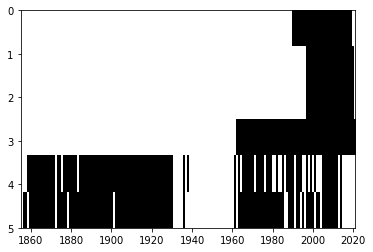

In [ ]:
def show_data_mask():
    '''Generates and shows a binary validness mask for all data.'''
    result = np.full((6, max_year - min_year + 1), False)

    is_na = np.full((2, max_year_temp - min_year_temp + 1), False)
    for i, df in enumerate((min_temps, max_temps)):
        for j, row in df.iterrows():
            is_na[i, row.year - min_year_temp] |= row.isna().temp

    result[4:] = is_na

    for i, df in enumerate((co2_emissions, industry_percent, agriculture_percent, gdp)):
        col_isna = df.isna().any(axis=0)
        result[i, min_year_wb - min_year:max_year_wb - min_year + 1] = col_isna.iloc[4:]
        result[i, :min_year_wb - min_year] = True
        result[i, max_year_wb - min_year + 1:] = True

    plt.imshow(result, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', extent=[min_year,max_year,5,0])
    plt.show()

show_data_mask()

For the temperature data we have a lot of years with missing data. This is problematic since it means we can only choose a small period for data observations. Let's look at available temperature data for each country.

In [ ]:
def show_temp_data_mask(df):
    '''Generates and shows a binary validness mask for temperature data.'''
    is_not_na = np.full((len(chosen_countries), max_year_temp - min_year_temp + 1), False)
    for i, country in enumerate(chosen_countries):
        for _, row in df[df.country == country].iterrows():
            is_not_na[i, row.year - min_year_temp] |= (not row.isna().temp)
    is_na = np.logical_not(is_not_na)
    ax = plt.figure().add_subplot(111)
    ax.imshow(is_na, aspect='auto', cmap=plt.cm.gray, interpolation='nearest', extent=[min_year,max_year,len(chosen_countries),0])
    ax.set_yticklabels(chosen_countries)
    plt.show()

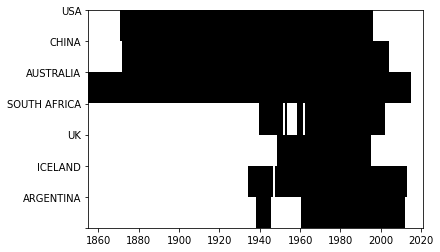

In [ ]:
# Mask for min temp data
show_temp_data_mask(min_temps)

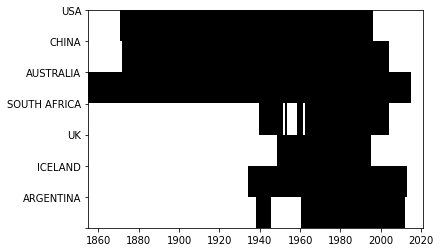

In [ ]:
# Mask for max temp data
show_temp_data_mask(max_temps)

From this we can see that not many countries' temperature data have sufficient overlap with other data (it also shows that there was incorrect assumption in the previous code since we didn't factor that the data might not be in the table at all and not just NaN).

There are several approaches we can take now. One of them is choose the countries which have enough overlap and leave the others out. The other one is to choose the earlier period (around 1995), where the data seems to be the most available.

Since we want to predict the temperature data and the other data is available enough, the simplest approach, which still allows to accomplish that goal and use the most recent data, is to choose only one country to use for temperature data (in this case, Australia). The next sections are going to proceed using that method.

In [ ]:
min_temps_aus = min_temps[min_temps.country == "AUSTRALIA"]
max_temps_aus = max_temps[max_temps.country == "AUSTRALIA"]

Now, let's find the most recent range of years where all the data is available.

In [ ]:
minimal_max_year = 2100
maximal_min_year = 0
for i, df in enumerate((co2_emissions, industry_percent, agriculture_percent, gdp)):
        col_isna = df.isna().any(axis=0).iloc[4:]
        for year in range(min_year_wb, max_year_wb + 1):
            if not col_isna.loc[str(year)]:
                maximal_min_year = max(maximal_min_year, year)
                break
        for year in reversed(range(min_year_wb, max_year_wb + 1)):
            if not col_isna.loc[str(year)]:
                minimal_max_year = min(minimal_max_year, year)
                break

# The first and last years in the range might have missing data
maximal_min_year = max(maximal_min_year, min_temps_aus[(min_temps_aus.temp.notna())].year.min()) + 1
minimal_max_year = min(minimal_max_year, min_temps_aus[(min_temps_aus.temp.notna())].year.max()) - 1
print(maximal_min_year, minimal_max_year)

1998 2014


The resulting range is from 1998 to 2014.

In [ ]:
min_temps_mask = (min_temps.year >= maximal_min_year) & (min_temps.year <= minimal_max_year)
min_temps_aus[min_temps_mask]

<ipython-input-24-53f5b0cdb46b>:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,station,country,year,month,temp
4831584,MELBOURNE,AUSTRALIA,1998,1,16.3
4831585,MELBOURNE,AUSTRALIA,1998,2,15.4
4831586,MELBOURNE,AUSTRALIA,1998,3,14.4
4831587,MELBOURNE,AUSTRALIA,1998,4,11.0
4831588,MELBOURNE,AUSTRALIA,1998,5,9.7
...,...,...,...,...,...
4831783,MELBOURNE,AUSTRALIA,2014,8,7.9
4831784,MELBOURNE,AUSTRALIA,2014,9,10.0
4831785,MELBOURNE,AUSTRALIA,2014,10,11.4
4831786,MELBOURNE,AUSTRALIA,2014,11,13.2


## Temperatures

Since we are going to be predicting temperatures, let's see if it is possible to see any trends or abnormalities in the data.

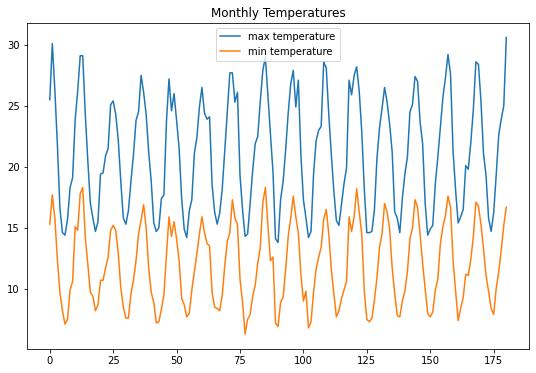

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(max_temps_aus[(max_temps_aus.year >= 2000) & (max_temps_aus.year <= 2015)].values[:, 4], label="max temperature")
plt.plot(min_temps_aus[(min_temps_aus.year >= 2000) & (min_temps_aus.year <= 2015)].values[:, 4], label="min temperature")
plt.title("Monthly Temperatures")
plt.legend()
plt.show()

As expected, the temperatures are periodic with the period corresponding to a year. There does not appear to be any problems or outliers in the data. However, from this plot it is not apparent if there is any general trend. It's a good idea to look at the larger time span to see if the trend is more visible. Since showing larger ranges with monthly measurements is going to be noisy, we are going to aggregate temperatures by year.

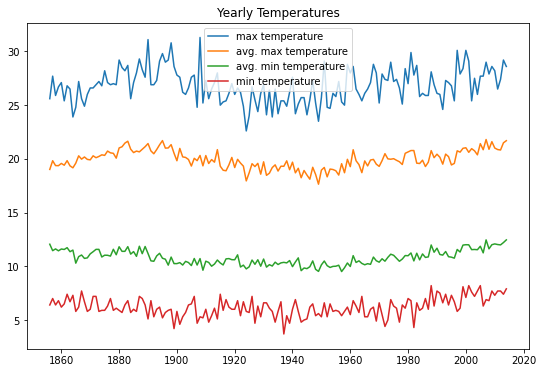

In [ ]:
max_temps_aus_agg = max_temps_aus.groupby(["station", "country", "year"]).agg({"temp": [np.max, np.mean]}).reset_index()
max_temps_aus_agg.columns = ['station', 'country', 'year', 'temp_ext', 'temp_mean']
min_temps_aus_agg = min_temps_aus.groupby(["station", "country", "year"]).agg({"temp": [np.min, np.mean]}).reset_index()
min_temps_aus_agg.columns = ['station', 'country', 'year', 'temp_ext', 'temp_mean']

plt.figure(figsize=(9,6))
plt.plot(
    max_temps_aus_agg.year.values[1:-7],
    max_temps_aus_agg.temp_ext.values[1:-7],
    label="max temperature"
)
plt.plot(
    max_temps_aus_agg.year.values[1:-7],
    max_temps_aus_agg.temp_mean.values[1:-7],
    label="avg. max temperature"
)
plt.plot(
    min_temps_aus_agg.year.values[1:-7],
    min_temps_aus_agg.temp_mean.values[1:-7],
    label="avg. min temperature"
)
plt.plot(
    min_temps_aus_agg.year.values[1:-7],
    min_temps_aus_agg.temp_ext.values[1:-7],
    label="min temperature"
)
plt.title("Yearly Temperatures")
plt.legend()
plt.show()

From the yearly temperatures it is apparent that there is a general trend. At the of the 19th century there was a temporary increase, which quickly dipped back, but after 1920s there appears to be a steady increase.

## GDP and Emissions

Now, we are going to look at the gdp and emissions data.

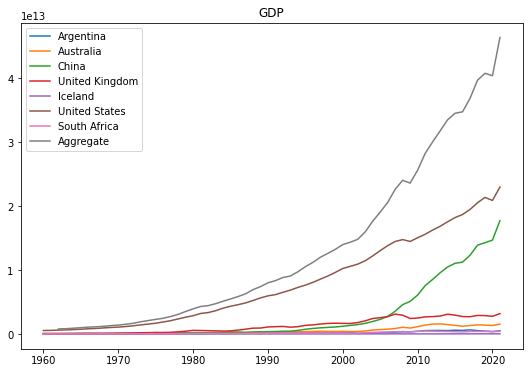

In [ ]:
country_names = gdp.values[:, 0]
gdp_per_year = gdp.values[:, 4:]
years = [*range(1960, 2022)]
plt.figure(figsize=(9, 6))
for i, name in enumerate(country_names):
    plt.plot(years, gdp_per_year[i], label=name)
plt.plot(years, gdp_per_year.sum(axis=0), label="Aggregate")
# plt.yscale("log")
plt.title("GDP")
plt.legend()
plt.show()

It can be seen that the gdp patterns for countries differ. For example, most countries have mostly stable gdp per year with only one significat increase between 2000 and 2010, but US and China still experiencing high growth. However, only China seems to have not transitioned into decreasing growth (deacceleration). Also, looking at aggregate gdp for these countries it can mostly be explained only by US and China's gdps.

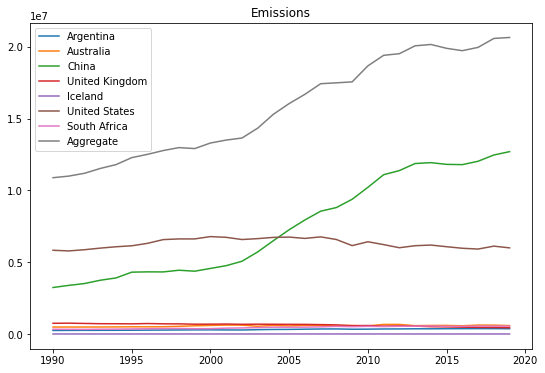

In [ ]:
country_names = co2_emissions.values[:, 0]
co2_per_year = co2_emissions.values[:, 4:]
years = [*range(1960, 2022)]
plt.figure(figsize=(9, 6))
for i, name in enumerate(country_names):
    plt.plot(years, co2_per_year[i], label=name)
plt.plot(years, co2_per_year.sum(axis=0), label="Aggregate")
# plt.yscale("log")
plt.title("Emissions")
plt.legend()
plt.show()

For emissions we have a similar picture to gdp. Total emissions are mostly explained by US and China, and China still drives the increase in emissions.

Now, let's take a look at proportion of gdp that is explained by industry and agriculture. This is important since they usually have larger effect on climate than other sectors of economy.

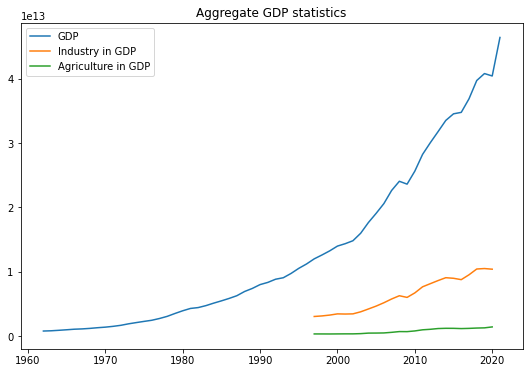

In [ ]:
country_names = industry_percent.values[:, 0]
industry_percent_per_year = industry_percent.values[:, 4:]
agriculture_percent_per_year = agriculture_percent.values[:, 4:]
gdp_per_year = gdp.values[:, 4:]
industry_in_gdp = industry_percent_per_year * gdp_per_year / 100.0
agriculture_in_gdp = agriculture_percent_per_year * gdp_per_year / 100.0
years = [*range(1960, 2022)]
plt.figure(figsize=(9, 6))

plt.plot(years, gdp_per_year.sum(axis=0), label="GDP")
plt.plot(years, industry_in_gdp.sum(axis=0), label="Industry in GDP")
plt.plot(years, agriculture_in_gdp.sum(axis=0), label="Agriculture in GDP")
# plt.yscale("log")
plt.title("Aggregate GDP statistics")
plt.legend()
plt.show()

From the graph we can see that both industry and argiculture do not have a large impact on gdp. The agriculture sector is mostly stable experiencing only minor growth, but industrial sector increase for than 2 fold in the 21st century.

Finally, let's look at all the aggregate statistics at the same time. Since they have different ranges, we are going to normalize them as a percent of the respective maximums.

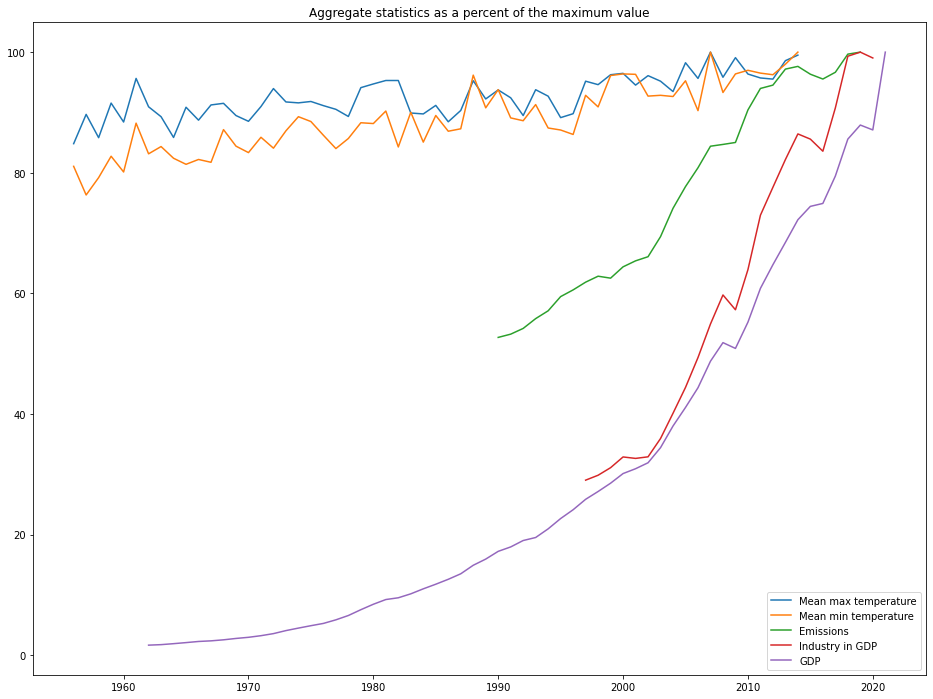

In [ ]:
def pct_of_max(values):
    values = values.astype(float)
    return values / values[~np.isnan(values)].max() * 100

plt.figure(figsize=(16, 12))
# plt.plot(max_temps_aus_agg.year.values[101:-7], pct_of_max(max_temps_aus_agg.temp_ext.values[101:-7]), label="Max temperature")
plt.plot(max_temps_aus_agg.year.values[101:-7], pct_of_max(max_temps_aus_agg.temp_mean.values[101:-7]), label="Mean max temperature")
plt.plot(min_temps_aus_agg.year.values[101:-7], pct_of_max(min_temps_aus_agg.temp_mean.values[101:-7]), label="Mean min temperature")
# plt.plot(min_temps_aus_agg.year.values[101:-7], pct_of_max(min_temps_aus_agg.temp_ext.values[101:-7]), label="Min temperature")
plt.plot(years, pct_of_max(co2_per_year.sum(axis=0)), label="Emissions")
plt.plot(years, pct_of_max(industry_in_gdp.sum(axis=0)), label="Industry in GDP")
plt.plot(years, pct_of_max(gdp_per_year.sum(axis=0)), label="GDP")

# plt.yscale("log")
plt.title("Aggregate statistics as a percent of the maximum value")
plt.legend()
plt.show()

The graph shows that while all the metrics experienced growth, they were not equal. The temperatures increase much more slower than others. Surprisingly, there is also a significant difference between minimum and maximum temperatures. The minimum temperatures experience quite a bit larger relative increase than the maximum temperatures.

From all of this, it can be concluded that the connection between emissions/economy and temperatures is not strikingly apparent. The problem might lie in several things: the effect is small and/or has a long delay, which is not obvious on such short ranges; or the interaction is complex. From these observations, I expect when modeling the data, the most important features are going to be previous temperatures and the date (due to generally linear trend on this range). Emissions and economy characteristics should also have an effect, but it is difficult to say if it will be significant or models will be able to detect it.

# Modeling

## Defining Common Function

In this section we are defining the functions that are going to be used during modeling. The 4 worldbank tables are also combined into one and transformed like in EDA (percent of maximum).

### Data Functions

In [ ]:
'''
Functions used to combined the worldbank data into one table
'''


def pct_of_max(values):
    '''Returns a new array with values replaced as percents of the maximum of the array'''
    values = values.astype(float)
    result = values / values.max(axis=1, keepdims=True)
    return result

def update_to_pct(df):
    '''Prepares worldbank table for combining'''
    result = df.copy().drop(
        ["Country Code", "Indicator Name", "Indicator Code", "2020", "2021"], axis=1
    ).fillna(method="backfill", axis=1)
    old_cols = result.columns[1:]
    pct = pct_of_max(result.values[:, 1:])

    new_cols = [col + "_pct" for col in old_cols]
    for i, col in enumerate(new_cols):
        result[col] = pct[:, i]
    return result


# Combining the worldbank tables into one table
worldbank_prefixes = ["_gdp", "_ind", "_agr", "_co2"]
combined_worldbank = pd.merge(
    pd.merge(
        pd.merge(
            update_to_pct(gdp),
            update_to_pct(industry_percent),
            how="outer", on="Country Name", suffixes=(worldbank_prefixes[0], worldbank_prefixes[1])),
        update_to_pct(agriculture_percent),
        how="outer", on="Country Name", suffixes=("", "")
    ),
    update_to_pct(co2_emissions),
    how="outer", on="Country Name", suffixes=(worldbank_prefixes[2], worldbank_prefixes[3])
)
print(combined_worldbank.isna().any().any())
combined_worldbank

False


,Country Name,1960_gdp,1961_gdp,1962_gdp,1963_gdp,1964_gdp,1965_gdp,1966_gdp,1967_gdp,1968_gdp,...,2010_pct_co2,2011_pct_co2,2012_pct_co2,2013_pct_co2,2014_pct_co2,2015_pct_co2,2016_pct_co2,2017_pct_co2,2018_pct_co2,2019_pct_co2
0,Argentina,24450604877.493401,24450604877.493401,24450604877.493401,18272123664.399399,25605249381.759701,28344705966.580101,28630474727.854599,24256667553.256901,26436857247.469601,...,0.900321,0.928528,0.941916,0.966252,0.962726,0.980886,0.989714,1.000000,0.994406,0.978367
1,Australia,18606786874.23,19683055213.3498,19922723709.262001,21539926083.548,23801097547.317699,25977153096.651402,27309889125.321999,30444618658.304401,32716989584.499901,...,0.847533,1.000000,0.998653,0.869138,0.893662,0.893228,0.859518,0.932564,0.923766,0.876769
2,China,59716467625.314796,50056868957.673203,47209359005.605698,50706799902.510399,59708343488.504303,70436266146.721893,76720285969.615707,72881631326.671494,70846535055.650299,...,0.804285,0.873523,0.896134,0.934903,0.939626,0.930215,0.928827,0.947279,0.981582,1.000000
3,United Kingdom,73233967692.102798,77741965703.354401,81247564156.8246,86561961812.324905,94407558351.161606,101824755078.990997,108572752102.044998,113116888210.787003,107759910067.889008,...,0.783050,0.726200,0.752883,0.729868,0.677561,0.657220,0.631053,0.611282,0.600450,0.582772
4,Iceland,248434096.968726,253885656.329253,284916516.159537,340061650.119898,434267936.914583,523694949.370689,628893310.399926,621225962.154708,474399471.622359,...,0.852243,0.802111,0.799472,0.844327,0.860158,0.873351,0.749340,0.762533,0.767810,0.751979
5,United States,543300000000.0,563300000000.0,605100000000.0,638600000000.0,685800000000.0,743700000000.0,815000000000.0,861700000000.0,942500000000.0,...,0.946910,0.917808,0.885619,0.906398,0.913068,0.896085,0.880179,0.872011,0.901900,0.884159
6,South Africa,8748596504.235809,9225996313.476391,9813996078.523451,10854195662.880501,11955995222.6234,13068994777.8911,14211394321.4111,15821393678.0875,17124793157.2752,...,0.952323,0.924188,0.960222,0.977695,1.000000,0.955889,0.956014,0.981885,0.980013,0.990318


In [ ]:
'''
Functions used for generating train and test data.
'''


def check_splits_for_nan(splits):
    '''Utility to check if the training splits contain invalid data.'''
    for ((X_train, y_train), (X_test, y_test)) in splits:
        if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
            print("There is a missing value in the data.")
            return True
    return False

data_min_year = 2000
def get_splits(get_data_for_month):
    '''
    Generates splits in the whole data range taking into account time dependencies.
    Uses a passed function pointer to generate data points.
    '''
    splits = []
    for predict_year in range(minimal_max_year - 4, minimal_max_year + 1):
        for predict_month in range(1, 13):
            X_test, y_test = get_data_for_month(predict_year, predict_month)
            X_test = X_test.reshape(1, -1)
            y_test = y_test.reshape(1, -1)

            n_train = (predict_year - data_min_year) * 12 + predict_month - 1
            X_train = []
            y_train = []
            for year in range(data_min_year, predict_year + 1):
                for month in range(1, 13):
                    if year == predict_year and month >= predict_month:
                        continue
                    x, y = get_data_for_month(year, month)
                    X_train.append(x)
                    y_train.append(y)
            X_train = np.array(X_train)
            y_train = np.array(y_train)


            splits.append([(X_train, y_train), (X_test, y_test)])

    print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))
    print(check_splits_for_nan(splits))
    return splits

def get_wb_cols(start_year, end_year):
    '''Utility to get column names in worldbank table for the specified (inclusive) range'''
    for year in range(start_year, end_year + 1):
        year = str(year)
        for prefix in worldbank_prefixes:
            yield year + "_pct" + prefix

def get_total_cols(start_year, end_year):
    '''Utility to get indices for aggregate co2 and gdp tables for the specified (inclusive) range'''
    for year in range(start_year - 1960, end_year - 1960 + 1):
        yield year

total_gdp_per_year = gdp_per_year.sum(axis=0)
total_gdp_per_year /= np.nanmax(total_gdp_per_year)
total_co2_per_year = co2_per_year.sum(axis=0)
total_co2_per_year /= np.nanmax(total_co2_per_year)
def get_total_for_year(year):
    '''Gets total gdp and co2 emissions for the previous 10 years'''
    last_10_year_gdp = total_gdp_per_year[list(get_total_cols(year - 10, year - 1))].astype(float).reshape(-1)
    last_10_year_co2 = total_co2_per_year[list(get_total_cols(year - 10, year - 1))].astype(float).reshape(-1)
    return last_10_year_gdp, last_10_year_co2

temps_aus = min_temps_aus.copy()
temps_aus["min_temp"] = temps_aus["temp"].copy()
temps_aus["max_temp"] = max_temps_aus["temp"].values
temps_aus.drop(["station", "country", "temp"], axis=1, inplace=True)
temps_aus_agg = temps_aus.groupby("year") \
                .agg({"min_temp": (np.min, np.mean), "max_temp": (np.max, np.mean)}) \
                .reset_index()
def get_last_10_year_temp(year):
    '''Gets aggregated temperatures for the previous 10 years'''
    last_10_year_mask = (temps_aus_agg.year >= year - 10) & (temps_aus_agg.year <= year - 1)
    return temps_aus_agg[last_10_year_mask].values[:, 1:].reshape(-1) / 25

def get_last_12_month_temp(year, month):
    '''Gets temperatures for the previos 12 months'''
    last_12_month_mask = (
        ((temps_aus.year == year - 1) & (temps_aus.month >= month)) |
        (((temps_aus.year == year) & (temps_aus.month < month)))
    ) 
    return temps_aus[last_12_month_mask][["min_temp", "max_temp"]].values.reshape(-1) / 25

def get_month_year(year, month):
    '''Normalized year and month values into a float range'''
    return [((month - 1) / 11 - 0.5) * 2, ((year - data_min_year) / 15 - 0.5) * 2]

def get_min_max(year, month):
    '''Gets the minimum and maximum temperatures for the specified month'''
    predict_mask = (temps_aus.year == year) & (temps_aus.month == month)
    temps_predict = temps_aus[predict_mask]
    return np.array(temps_predict[["min_temp", "max_temp"]]).reshape(-1)

def get_last_10_year_wb(year):
    '''Gets all the worldbank data for the previous 10 years.'''
    return combined_worldbank[get_wb_cols(year - 10, year - 1)].values.astype(float).reshape(-1)

combined_wb_aus = combined_worldbank[combined_worldbank["Country Name"] == "Australia"]
def get_last_10_year_wb_aus(year):
    '''Gets only Australia's worldbank data for the previous 10 years.'''
    return combined_wb_aus[get_wb_cols(year - 10, year - 1)].values.astype(float).reshape(-1)

def get_last_year_wb_aus(year):
    '''Gets only Australia's worldbank data for the previous year.'''
    return combined_wb_aus[get_wb_cols(year - 1, year - 1)].values.astype(float).reshape(-1)

combined_wb_wo_aus = combined_worldbank[combined_worldbank["Country Name"] != "Australia"]
def get_last_10_year_wb_wo_aus(year):
    '''Gets all the worldbank data except for Australia for the previous 10 years.'''
    return combined_wb_wo_aus[get_wb_cols(year - 10, year - 1)].values.astype(float).reshape(-1)

### Metric Function

In [ ]:
def rmse(predicted, true):
    '''Root mean square error'''
    return np.sqrt(mean_squared_error(true, predicted))

### Visualization Functions

In [ ]:
def show_corr(data):
    '''Computes and plots pairwise correlations'''
    corr = np.corrcoef(data, rowvar=False)
    plt.figure(figsize=(6, 6))
    sns.heatmap(corr)
    plt.show()

def show_forest_importance(model):
    '''
    Displays feature importance for a RandomForest model.

    Reference code from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    '''
    forest = model.estimators_[0]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=range(importances.shape[0]))

    fig, ax = plt.subplots(figsize=(16, 4))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def train_and_show_forest(splits, n_est):
    '''
    Trains and displays feature importance for a RandomForest model.
    '''
    ((X_train, y_train), (X_test, y_test)) = splits[-1]
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_est))
    model = model.fit(X_train, y_train)
    print(f"RMSE = {rmse(model.predict(X_test), y_test):.2}")

    show_forest_importance(model)

### Training Functions

In [ ]:
def train_linear(splits, verbose=False, alphas=(100, 10, 5, 3, 1, 0.5, 0.3, 0.1, 0.05, 0.01, 0.001, 0.0005)):
    '''
    Performs a hyperparamater search for Lasso and Ridge regressions and displays best results.
    '''
    print("Without scaling the data")
    max_iter = 5000
    for model_cls in (Lasso, Ridge):
        if verbose: print(" Best alpha for", model_cls.__name__)
        best = (float("inf"), None)
        for alpha in alphas:
            mean_rmse = 0
            for ((X_train, y_train), (X_test, y_test)) in splits:
                model = model_cls(alpha=alpha, max_iter=max_iter).fit(X_train, y_train)
                mean_rmse += rmse(model.predict(X_test), y_test)
            mean_rmse /= len(splits)
            if mean_rmse < best[0]:
                best = (mean_rmse, alpha)
                if verbose: print(best)
        print(f"  Best for {model_cls.__name__}: alpha={best[1]}, rmse={best[0]:.3f}")

    print("\nWith scaling only the features (not the targets)")
    for model_cls in (Lasso, Ridge):
        if verbose: print(" Best alpha for", model_cls.__name__)
        best = (float("inf"), None)
        for alpha in alphas:
            mean_rmse = 0
            for ((X_train, y_train), (X_test, y_test)) in splits:
                scaler = StandardScaler().fit(X_train)
                model = model_cls(alpha=alpha, max_iter=max_iter).fit(scaler.transform(X_train), y_train)
                mean_rmse += rmse(model.predict(scaler.transform(X_test)), y_test)
            mean_rmse /= len(splits)
            if mean_rmse < best[0]:
                best = (mean_rmse, alpha)
                if verbose: print(best)
        print(f"  Best for {model_cls.__name__}: alpha={best[1]}, rmse={best[0]:.3f}")

    print("\nWith scaling all the data")
    for model_cls in (Lasso, Ridge):
        if verbose: print(" Best alpha for", model_cls.__name__)
        best = (float("inf"), None)
        for alpha in alphas:
            mean_rmse = 0
            for ((X_train, y_train), (X_test, y_test)) in splits:
                x_scaler = StandardScaler().fit(X_train)
                y_scaler = StandardScaler().fit(y_train)
                model = model_cls(alpha=alpha, max_iter=max_iter).fit(x_scaler.transform(X_train), y_scaler.transform(y_train))
                mean_rmse += rmse(
                    y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), y_test
                )
            mean_rmse /= len(splits)
            if mean_rmse < best[0]:
                best = (mean_rmse, alpha)
                if verbose: print(best)
        print(f"  Best for {model_cls.__name__}: alpha={best[1]}, rmse={best[0]:.3f}")

def train_boosting(splits, verbose=False):
    '''
    Performs a hyperparamater search for GradientBoostingRegressor and displays best results.
    '''
    best = (float("inf"), None, None)
    for lr in (1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001):
        if verbose: print(lr)
        for n_est in (200, 100, 80, 50, 20, 5):
            mean_rmse = 0
            for ((X_train, y_train), (X_test, y_test)) in splits:
                model = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=lr, n_estimators=n_est))
                model = model.fit(X_train, y_train)
                mean_rmse += rmse(model.predict(X_test), y_test)
            mean_rmse /= len(splits)
            if mean_rmse < best[0]:
                best = (mean_rmse, lr, n_est)
                if verbose: print(best)
    print(f" Learning rate={best[1]}, estimators={best[2]}, rmse={best[0]:.3f}")

def train_forest(splits, verbose=False):
    '''
    Performs a hyperparamater search for RandomForestRegressor and displays best results.
    '''
    best = (float("inf"), None)
    for n_est in (5, 20, 50, 80, 100, 300, 500):
        mean_rmse = 0
        for ((X_train, y_train), (X_test, y_test)) in splits:
            model = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_est, n_jobs=-1))
            model = model.fit(X_train, y_train)
            mean_rmse += rmse(model.predict(X_test), y_test)
        mean_rmse /= len(splits)
        if mean_rmse < best[0]:
            best = (mean_rmse, n_est)
            if verbose: print(best)
    print(f" Estimators={best[1]}, rmse={best[0]:.3f}")

def train_lasso(splits, alpha):
    '''Trains a Lasso model'''
    ((X_train, y_train), (X_test, y_test)) = splits[-1]
    model = Lasso(alpha=alpha).fit(X_train, y_train)
    print("RMSE =", rmse(model.predict(X_test), y_test))
    return model

## Modeling using only Australia's temperature data

First, we are going to see what kind of performance is possible to achieve using only temperatures and dates.

It is important to note that the data is time-dependent. Because of that we can't just randomly split data for cross-validation. Instead we are going to train on slices of data based on time (e.g. predict for year 2010 using a model trained on the data from 2009 and before, then repeat for 2011, ... 2014). The validation score for all slices then will be averaged to get the validation score for the model.

Since we have a lot of data, we are going to use only a few aggregated features for predicting. With temperatures it's going to be measurements for the previous 12 months and aggregated statistics for the previous 10 years. The date is also normalized and concatenated to the rest of the features. The targets are the minimum and the maximum temperatures for the specified date.

In [ ]:
def get_data_for_month(year, month):
    '''Gets temperature data, date data and targets.'''
    y = get_min_max(year, month)
    
    last_12_month = get_last_12_month_temp(year, month)
    last_10_year = get_last_10_year_temp(year)
    month_year = get_month_year(year, month)
    x = np.concatenate((last_12_month, last_10_year, month_year))

    return x, y

splits = get_splits(get_data_for_month)

((179, 66), (179, 2)) ((1, 66), (1, 2))
False


For training both Lasso and Ridge linear regressions are used. To find the best hyperparameters each model is run using three types of scaling (none, only features, features and targets) and with a range of a norm coefficient (alpha).

In [ ]:
train_linear(splits)

Without scaling the data
  Best for Lasso: alpha=0.01, rmse=0.834
  Best for Ridge: alpha=1, rmse=0.869

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.1, rmse=0.897
  Best for Ridge: alpha=10, rmse=0.913

With scaling all the data
  Best for Lasso: alpha=0.01, rmse=0.916
  Best for Ridge: alpha=10, rmse=0.913


In [ ]:
splits[-1][0][1][:, 0].std(), splits[-1][0][1][:, 1].std()

(3.2256008909899925, 4.530925675336345)

Training linear models we get cross-validation RMSE of 0.834. This result is good considering that the standard errors for minimum and maximum temperatures are 3.226 and 4.531 respectively.

Since we trained a Lasso model, we can look at what features have zero coefficients in order to see, which ones had an impact.

In [ ]:
model = train_lasso(splits, 0.01)
nonzero_last_12_months = (model.coef_[:, :24] != 0.0).sum()
nonzero_last_10_years = (model.coef_[:, 24:64] != 0.0).sum()
nonzero_date = (model.coef_[:, 64:66] != 0.0).sum()
print("Number of nonzero coefs corresponding to features for the last 12 months:", nonzero_last_12_months, nonzero_last_12_months / 24 / 2)
print("Number of nonzero coefs corresponding to features for the last 10 years:", nonzero_last_10_years, nonzero_last_10_years / 40 / 2)
print("Number of nonzero coefs corresponding to date features:", nonzero_date, nonzero_date / 2 / 2)

RMSE = 0.4799944352181334
Number of nonzero coefs corresponding to features for the last 12 months: 21 0.4375
Number of nonzero coefs corresponding to features for the last 10 years: 0 0.0
Number of nonzero coefs corresponding to date features: 4 1.0


In [ ]:
model.coef_[0, :24].reshape(-1, 2), model.coef_[0, 64:]

(array([[ 0.        ,  2.24578556],
        [ 0.        ,  1.56636783],
        [ 0.        ,  2.50288087],
        [ 0.        ,  0.        ],
        [-0.        , -0.56131628],
        [-0.        , -0.        ],
        [-0.        , -2.74482348],
        [-0.34902388, -0.88817658],
        [-0.        , -1.53408079],
        [-0.        , -0.        ],
        [ 0.        ,  0.        ],
        [ 0.19946357,  7.54252611]]), array([-0.84504575,  0.14975655]))

As expected all the date features and half of the temperatures from the previous 12 months were used. However, surprisingly, the yearly statistics seem to be not useful. This might be explained by the usage of the date features since yearly statistics might be explained just by the linear trend we saw in EDA.

To check that let's look at the correlation matrix (the first 24 features are monthly temperatures, the next 40 are yearly statistics, the last 4 are date features and the targets). 

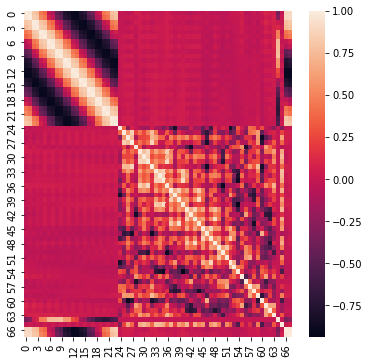

In [ ]:
show_corr(np.concatenate((splits[0][0][0], splits[0][0][1]), axis=1))

From this we can see that normalized year correlates with yearly statistics and normalized month correlates with monthly temperatures. There is also a lot of correlation between the two large groups of features: monthly and yearly.

This kind of correlation might negatively affect linear model even with regularization. To see if it is the case, we are going to train two other types of models: gradient boosting model and random forest.

Note: both gradient boosting models and random forests take a lot of time to run. Because of that only different amounts of estimators and values of learning rate tried in the hyperparameter search in order to decrease runtime.

In [ ]:
train_boosting(splits)

 Learning rate=0.05, estimators=80, rmse=0.917


In [ ]:
train_forest(splits)

 Estimators=300, rmse=0.920


Both of those models performed worse than linear models. This indicated that multicollinearity was not a problem.

Another benefit of training a random forest is that we can compare the feature importance for this model versus linear.

RMSE = 0.81


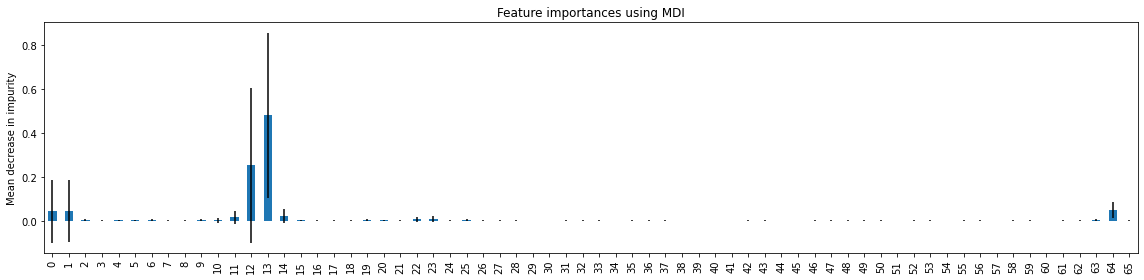

In [ ]:
((X_train, y_train), (X_test, y_test)) = splits[-1]
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=300))
model = model.fit(X_train, y_train)
print(f"RMSE = {rmse(model.predict(X_test), y_test):.2}")

show_forest_importance(model)

The results are similar to the linear model. The important features are dates and monthly temperatures. The random forest also shows that the most important features are temperatures in summer and winter and current month.

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 0.869       |
| Lasso   | 0.843       |
| Gradient Boosting   | 0.917       |
| Random Forest   | 0.920       |

## Modeling using only Australia's industry data

Now we are going to try predicting temperatures using only the date and the industry data. Just as before, we are going to aggregate the 4 economic charateristics (normalized to be a percent of the maximum value) by year and use the previous 10 years.

In [ ]:
def get_data_for_month(year, month):
    '''Gets Australia's worldbank data, date data and targets.'''
    y = get_min_max(year, month)

    last_10_year = get_last_10_year_wb_aus(year)
    month_year = get_month_year(year, month)
    x = np.concatenate((last_10_year, month_year))

    return x, y

splits = get_splits(get_data_for_month)

((179, 42), (179, 2)) ((1, 42), (1, 2))
False


In [ ]:
train_linear(splits)

Without scaling the data
  Best for Lasso: alpha=0.1, rmse=3.376
  Best for Ridge: alpha=10, rmse=3.425

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.5, rmse=3.399
  Best for Ridge: alpha=100, rmse=3.615

With scaling all the data
  Best for Lasso: alpha=0.1, rmse=3.394
  Best for Ridge: alpha=100, rmse=3.615


In [ ]:
splits[-1][0][1][:, 0].std(), splits[-1][0][1][:, 1].std()

(3.2256008909899925, 4.530925675336345)

Compared to the previous models, these linear models do not perform well (they are close to being equal in performance to predicting mean value).

In [ ]:
model = train_lasso(splits, 0.1)
nonzero_last_10_years = (model.coef_[:, :40] != 0.0).sum()
nonzero_date = (model.coef_[:, 40:42] != 0.0).sum()
print("Number of nonzero coefs corresponding to features for the last 10 years:", nonzero_last_10_years, nonzero_last_10_years / 40 / 2)
print("Number of nonzero coefs corresponding to date features:", nonzero_date, nonzero_date / 2 / 2)

RMSE = 5.40846649217537
Number of nonzero coefs corresponding to features for the last 10 years: 0 0.0
Number of nonzero coefs corresponding to date features: 2 0.5


Looking at the features that didn't turn into 0 during training, we can see that Lasso only used the date features. This shows that the effect from economic characteristics is not linear.

Now let's see if other models can exploit the interaction.

In [ ]:
train_boosting(splits)

 Learning rate=0.05, estimators=80, rmse=0.770


In [ ]:
train_forest(splits)

 Estimators=100, rmse=0.838


RMSE = 0.62


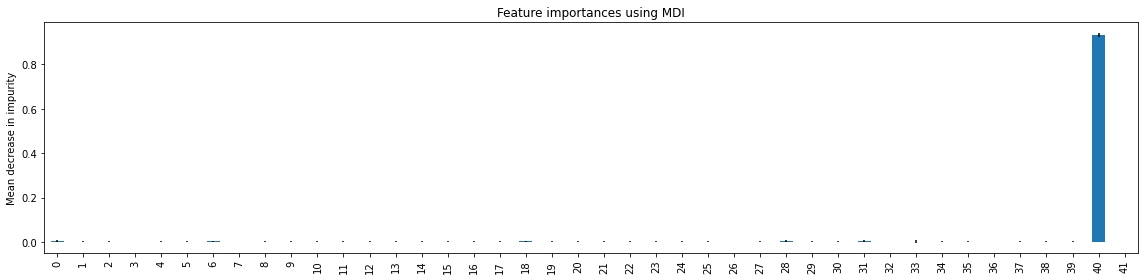

In [ ]:
train_and_show_forest(splits, 100)

In this case, we again see that the economic characteristics almost do not contribute to the final prediction. However, the performance of the gradient boosting model is the best so far, which is surprising considerting that the model does not have access to histrorical temperatures during prediction.

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 3.425       |
| Lasso   | 3.376      |
| Boosting   | 0.770       |
| Random Forest   | 0.838       |

## Modeling using only not Australia's data

Now let's try what performance is achievable using the economic data from other countries and date.

In [ ]:
def get_data_for_month(year, month):
    '''Gets all worldbank data except for Australia, date data and targets.'''
    y = get_min_max(year, month)

    last_10_year = get_last_10_year_wb_wo_aus(year)
    month_year = get_month_year(year, month)
    x = np.concatenate((last_10_year, month_year))

    return x, y

splits = get_splits(get_data_for_month)

((179, 242), (179, 2)) ((1, 242), (1, 2))
False


In [ ]:
train_linear(splits)

Without scaling the data
  Best for Lasso: alpha=0.1, rmse=3.376
  Best for Ridge: alpha=100, rmse=3.473

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.5, rmse=3.398
  Best for Ridge: alpha=0.0005, rmse=3.667

With scaling all the data
  Best for Lasso: alpha=0.1, rmse=3.389
  Best for Ridge: alpha=0.0005, rmse=3.667


Just like with the previous model the linear model is unable to perform well.

In [ ]:
train_boosting(splits)

 Learning rate=0.05, estimators=80, rmse=0.824


In [ ]:
train_forest(splits)

 Estimators=80, rmse=0.831


RMSE = 0.64


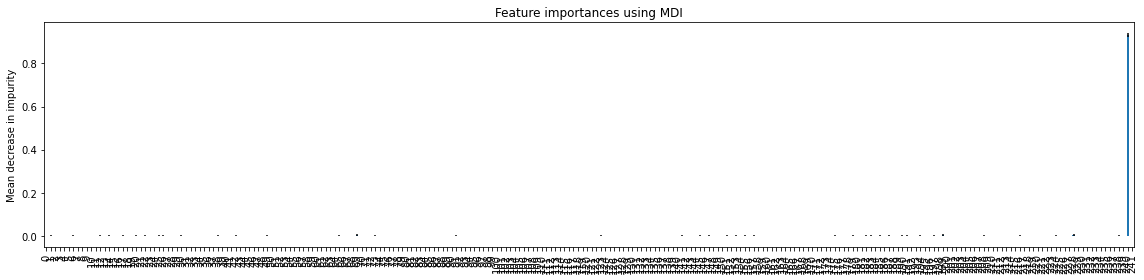

In [ ]:
train_and_show_forest(splits, 80)

Overall, the result is very similar to the one in the previous section. The performance is slightly worse, but that is probably due to overfitting to too many features.

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 3.473       |
| Lasso   | 3.376      |
| Boosting   | 0.824       |
| Random Forest   | 0.831       |

## Modelling using all data

Now that we tried using subsections of the data, we are going to try modelling with all available data. This will result in many features and they are probably not that significant given previous experiments, but there is a chance that models might discover new patterns.

In [ ]:
def get_data_for_month(year, month):
    '''Gets all worldbank data, temperature data, date data and targets.'''
    y = get_min_max(year, month)

    last_12_month = get_last_12_month_temp(year, month)
    last_10_year = get_last_10_year_temp(year)
    last_10_year_wb = get_last_10_year_wb(year)
    month_year = get_month_year(year, month)
    x = np.concatenate((last_12_month, last_10_year, last_10_year_wb, month_year))

    return x, y

splits = get_splits(get_data_for_month)

((179, 346), (179, 2)) ((1, 346), (1, 2))
False


In [ ]:
train_linear(splits)

Without scaling the data
  Best for Lasso: alpha=0.01, rmse=0.852
  Best for Ridge: alpha=0.3, rmse=0.918

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.1, rmse=0.908
  Best for Ridge: alpha=10, rmse=0.937

With scaling all the data
  Best for Lasso: alpha=0.05, rmse=0.924
  Best for Ridge: alpha=10, rmse=0.937


In [ ]:
train_boosting(splits)

 Learning rate=0.1, estimators=50, rmse=0.902


In [ ]:
train_forest(splits)

 Estimators=500, rmse=0.925


RMSE = 0.78


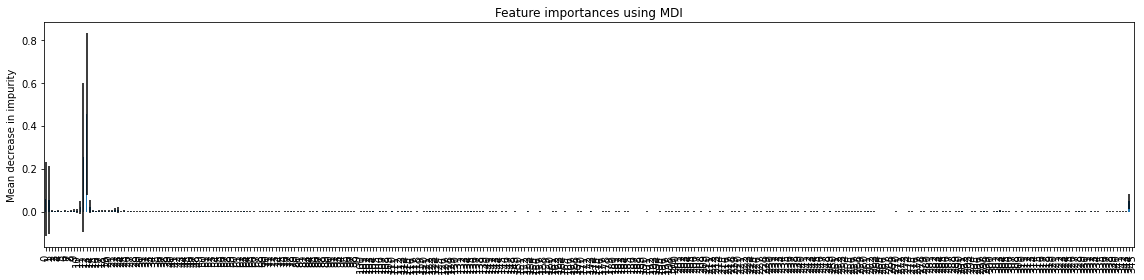

In [ ]:
train_and_show_forest(splits, 500)

In this case, the models seems to be exploting only monthly temperatures and date. The performance in general is still worse when using only Australia's economic characteristics. This is probably due to having too many features compared to the size of training data.

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 0.918       |
| Lasso   | 0.852      |
| Boosting   | 0.902       |
| Random Forest   | 0.925     |

## Modeling using only dates

From the previous experiments, we can see that the date is one of the most significant features and it's not clear how much other features help. To test this out we are going to train models using only dates.

In [ ]:
def get_data_for_month(year, month):
    '''Gets date data and targets.'''
    y = get_min_max(year, month)
    x = np.array(get_month_year(year, month))
    return x, y

splits = get_splits(get_data_for_month)

((179, 2), (179, 2)) ((1, 2), (1, 2))
False


In [ ]:
train_linear(splits)

Without scaling the data
  Best for Lasso: alpha=0.1, rmse=3.376
  Best for Ridge: alpha=0.0005, rmse=3.388

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.3, rmse=3.376
  Best for Ridge: alpha=0.0005, rmse=3.388

With scaling all the data
  Best for Lasso: alpha=0.05, rmse=3.376
  Best for Ridge: alpha=0.0005, rmse=3.388


In [ ]:
train_boosting(splits)

 Learning rate=0.1, estimators=50, rmse=0.802


In [ ]:
train_forest(splits)

 Estimators=80, rmse=0.916


RMSE = 0.64


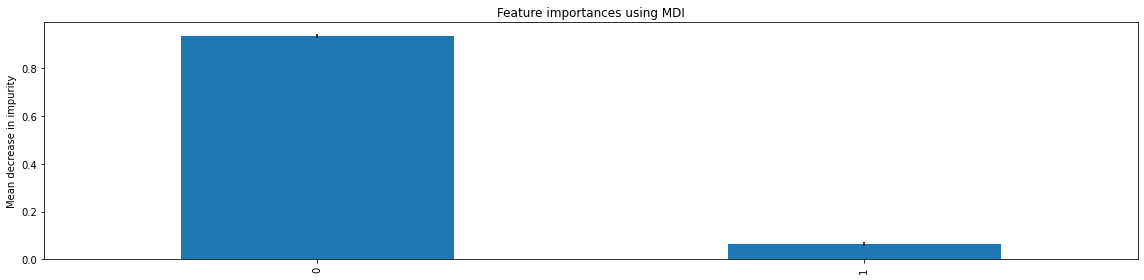

In [ ]:
train_and_show_forest(splits, 80)

As expected from the previous experiments models using only dates perform well (except for linear models since the relation is not linear). However, these models still perform worse than the ones also using Australia's industry data. 

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 3.388       |
| Lasso   | 3.376      |
| Boosting   | 0.802       |
| Random Forest   | 0.916     |

| Data      | Model | RMSE |
| ----------- | ----------- |-|
| Temperature+Date   | Lasso   | 0.843       |
| AusInd+Date  | Boosting | 0.770      |
| OtherInd+Date  | Boosting | 0.852       |
| All+Date   | Lasso | 0.852     |
| Date| Boosting | 0.802 |

## Random kitchen sinks

In this section we are going to try some feature engineering to improve performance of linear models using only dates. Since dates and temperatures do not have a linear relationship, we need to come up with ways to combine the features to reveal the linear relationship. This is requires specialized work with data and understanding of the domain. Another method is Random Kitchen Sinks, which allows to generate random combinations of features with a high chance of getting 'good' composite features.

Note: RKS is a simple method utilizing knowledge from kernel methods. The basic idea is that we can linearly combine features with weights sampled from a Fourier's transform of a kernel and pass them through a Euler's identity (sin and cos) to get an effect similar to a kernel trick. If the number of features generated is large, we are closer to a kernel method. However, only a few are needed to be generated to get a good performance. It works best with 'linear' methods.

In [ ]:
def get_data_for_month(year, month):
    '''Gets aggregate date data and targets.'''
    y = get_min_max(year, month)

    month_year = get_month_year(year, month)
    x = np.array(month_year)

    return x, y

splits = get_splits(get_data_for_month)

((179, 2), (179, 2)) ((1, 2), (1, 2))
False


In [ ]:
def rks(X, w, b):
    '''Computes random kitchen sinks (exp(i*W*x)) given coefficients
    
    References and explanations from:
        https://people.eecs.berkeley.edu/~brecht/kitchensinks.html
        https://www.stat.cmu.edu/~cshalizi/sml/21/lectures/22/lecture-22.html#(1)
        https://people.eecs.berkeley.edu/~brecht/papers/08.rah.rec.nips.pdf
    '''
    cos = np.cos(X @ w.T + b)
    sin = np.sin(X @ w.T + b)
    result = np.concatenate((cos, sin), axis=1)
    return result


k = 19
w = np.random.randn(k, 2)
b = np.random.uniform(low=-np.pi, high=np.pi, size=(k,))
rks_splits = []
for ((X_train, y_train), (X_test, y_test)) in splits:
    rks_splits.append((
        (np.concatenate((X_train, rks(X_train[:, -2:], w, b)), axis=1), y_train),
        (np.concatenate((X_test, rks(X_test[:, -2:], w, b)), axis=1), y_test)
    ))

In [ ]:
train_linear(rks_splits)

Without scaling the data
  Best for Lasso: alpha=0.0005, rmse=1.007
  Best for Ridge: alpha=0.001, rmse=0.961

With scaling only the features (not the targets)
  Best for Lasso: alpha=0.0005, rmse=0.938
  Best for Ridge: alpha=0.01, rmse=0.943

With scaling all the data
  Best for Lasso: alpha=0.0005, rmse=1.025
  Best for Ridge: alpha=0.01, rmse=0.943


In [ ]:
train_boosting(rks_splits)

 Learning rate=0.05, estimators=80, rmse=1.035


In [ ]:
train_forest(rks_splits)

 Estimators=100, rmse=1.013


RMSE = 0.55


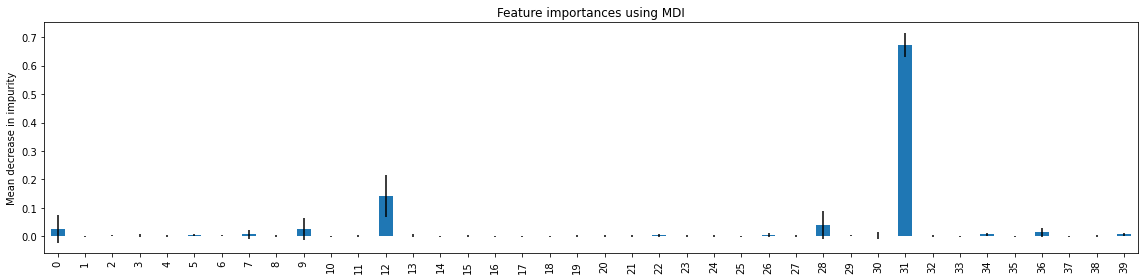

In [ ]:
train_and_show_forest(rks_splits, 100)

We can see the performance of linear models increases dramatically. However, RMSE scores for the other 2 models decrease, which is to be expected considering that they do not have problems with modelling nonlinear relationships and additional features usually decrease performance due to overfitting.

| Model      | RMSE |
| ----------- | ----------- |
| Ridge      | 0.943       |
| Lasso   | 0.938      |
| Boosting   | 1.035      |
| Random Forest   | 1.013    |

## Final hyperparameter optimisation

With all the modelling done, we are going to do more thorough hyperparameter optimization for the best model, which is a Gradient Boosting model on dates and Australia's economic data.

In [ ]:
def get_data_for_month(year, month):
    '''Gets Australia's worldbank data, date data and targets.'''
    y = get_min_max(year, month)

    last_10_year = get_last_10_year_wb_aus(year)
    month_year = get_month_year(year, month)
    x = np.concatenate((last_10_year, month_year))

    return x, y

splits = get_splits(get_data_for_month)

((179, 42), (179, 2)) ((1, 42), (1, 2))
False


In [ ]:
best = (float("inf"), None, None, None)
for lr in (0.3, 0.1, 0.08, 0.05, 0.03, 0.01, 0.007):
    print(lr)
    for n_est in (100, 90, 80, 70):
        for max_depth in (3, 4, 5):
            mean_rmse = 0
            for ((X_train, y_train), (X_test, y_test)) in splits:
                model = MultiOutputRegressor(
                    GradientBoostingRegressor(learning_rate=lr, n_estimators=n_est, max_depth=max_depth)
                )
                model = model.fit(X_train, y_train)
                mean_rmse += rmse(model.predict(X_test), y_test)
            mean_rmse /= len(splits)
            if mean_rmse < best[0]:
                best = (mean_rmse, lr, n_est, max_depth)
                print(best)
print(f" Learning rate={best[1]}, estimators={best[2]}, max depth={best[3]} rmse={best[0]:.3f}")

0.3
(0.902916487430672, 0.3, 100, 3)
(0.8860891946115792, 0.3, 90, 3)
0.1
(0.8392052244805235, 0.1, 100, 3)
(0.8201723226910628, 0.1, 90, 3)
(0.8136960536019654, 0.1, 80, 3)
(0.8108469249794397, 0.1, 70, 3)
0.08
(0.7930762449232067, 0.08, 100, 3)
(0.7928347985978018, 0.08, 90, 3)
(0.7838355156236883, 0.08, 80, 3)
(0.7685034301645731, 0.08, 70, 3)
0.05
(0.7662460819225149, 0.05, 80, 3)
0.03
0.01
0.007
 Learning rate=0.05, estimators=80, max depth=3 rmse=0.766


This time we got unlucky and the hyperparameters used before already were the best. Due to some randomness during trianing, RMSE decreased but not by much.

The final RMSE score is 0.766.

# Discussions

In this project we tried to predict future temperatures using historical temperature and economic data. From the experiments it can be concluded that much of the prediction in the short range can be made using only the current year and date. The best results for each training data configuration are shown below.

| Data      | Model | RMSE |
| ----------- | ----------- |-|
| Aus. Ind. + Date  | Boosting | 0.766      |
| Date | Boosting | 0.802 |
| Temperature + Date   | Lasso   | 0.843       |
| Other Ind. + Date  | Boosting | 0.852       |
| All + Date   | Lasso | 0.852     |

From these results we can see that only when using economic data from Australia were we able to achieve better performance than when using only dates. This result is a bit surprising considering that contributions of economic features was small compared to dates, but maybe it was still enough to provide a small improvement to the validation score. The other point to consider is the overall short range of the data used during modelling, which might have scewed or hid the more complex trend over a larger period.

In order to further improve performance several steps are possible. First, the more specialized feature engineering can help. That would require either doing a deep research into climate science or asking for assistance from domain experts. Another avenue of improvement is increasing the data range both for the training data and validation data. This would allow for more complex patterns (if they exists) to be observable. To do that more data needs to be collected, which is difficult due to the amount of sources and problems with those sources (restrictive licenses, too specialized data, missing and erronous data, etc.). The final thing that can be done is trying to see if the problem lies in not using methods more suitable for modelling time series data.



# Contributions and takeaways

The project's goal was to experiment with ways to predict minimum and maximum temperatures. For that the data was collected from two different sources. Working with several sources showed that doing so is more complex than using a single source due to differences in data formats, data availability and different quirks in how the sources collected and processed data. Doing preliminary EDA revealed problems in the data connected to the data availability in different time periods. EDA also was useful to form initial hypothesis, one of them being that the economic features wouldn't be too useful for modelling without extensive feature engineering or large data ranges. The modelling itself was done using a number of different data subsets and models. This allowed to understand better how the features did or did not interacat and how the choice of the model influences which features are useful. Additionaly, a method called Random Kitchen Sinks was used to show how new features can be randomly and quickly generated without much work in order to improve the performance of linear models.